<a href="https://colab.research.google.com/github/kalyani234/modelling_optimisation_cw1/blob/modelling_cw/Amazon_LDA_LSA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pyLDAvis

In [ ]:
!pip install bokeh

In [ ]:
# Ensure all necessary libraries are installed
!pip install pandas numpy matplotlib seaborn wordcloud gensim scikit-learn spacy nltk pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import TSNE
import pyLDAvis
import pyLDAvis.gensim
import bokeh.plotting as bk
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10, Category20
from gensim.models.coherencemodel import CoherenceModel
import spacy
from nltk.corpus import stopwords
import string
import re
import nltk
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# To suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Initialize Bokeh for notebook
output_notebook()

In [ ]:
# Download NLTK stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initialize spacy and stopwords
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop = set(stopwords.words('english'))
# Add custom stopwords
custom_stopwords = {'amazon', 'kindle', 'fire', 'product', 'review', 'use', 'read','one'}
stop.update(custom_stopwords)
exclude = set(string.punctuation)

In [ ]:
# Loading the dataset
df = pd.read_csv("/content/7817_1 2.csv")

## Displaying dataset info before preprocessing

In [ ]:
# number of rows and columns
df.shape

(1597, 27)

In [ ]:
# print 5 rows
print(df.head())

                     id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2 

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [ ]:
# findind Missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
id                         0
asins                      0
brand                      0
categories                 0
colors                   823
dateAdded                  0
dateUpdated                0
dimension               1032
ean                      699
keys                       0
manufacturer             632
manufacturerNumber       695
name                       0
prices                     0
reviews.date             380
reviews.doRecommend     1058
reviews.numHelpful       697
reviews.rating           420
reviews.sourceURLs         0
reviews.text               0
reviews.title             17
reviews.userCity        1597
reviews.userProvince    1597
reviews.username          17
sizes                   1597
upc                      699
weight                   911
dtype: int64


In [ ]:
# Drop unnecessary columns and rows with missing values
df = df.drop(['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'keys',
              'name', 'prices', 'reviews.date', 'reviews.doRecommend', 'reviews.numHelpful',
              'reviews.rating', 'reviews.sourceURLs', 'reviews.username'], axis=1)

In [ ]:
df = df.dropna(subset=['reviews.text', 'reviews.title'])

In [ ]:
# Drop duplicate rows
df = df.drop_duplicates(subset=['reviews.text', 'reviews.title'])

In [ ]:
# Reset index
df = df.reset_index(drop=True)

## Displaying dataset info after dropping unnecessary columns and rows

In [ ]:
print("\nDataset Info After Dropping Unnecessary Columns and Rows:")
print(df.info())
print("\nSample Data:")
print(df.head())


Dataset Info After Dropping Unnecessary Columns and Rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   colors                760 non-null    object 
 1   dimension             565 non-null    object 
 2   ean                   843 non-null    float64
 3   manufacturer          910 non-null    object 
 4   manufacturerNumber    849 non-null    object 
 5   reviews.text          1413 non-null   object 
 6   reviews.title         1413 non-null   object 
 7   reviews.userCity      0 non-null      float64
 8   reviews.userProvince  0 non-null      float64
 9   sizes                 0 non-null      float64
 10  upc                   843 non-null    float64
 11  weight                675 non-null    object 
dtypes: float64(5), object(7)
memory usage: 132.6+ KB
None

Sample Data:
  colors                 dimension  ean manufac

In [ ]:
# Data Preprocessing Function
def clean(doc):
    doc = re.sub(r'\s+', ' ', doc)  # Remove extra whitespaces
    doc = re.sub(r'\d+', '', doc)  # Remove numbers
    doc = re.sub(r'\W+', ' ', doc)  # Remove non-alphanumeric characters
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    doc = nlp(punc_free)
    normalized = " ".join(token.lemma_ for token in doc if token.lemma_ not in stop and len(token.lemma_) > 1)
    return normalized

In [ ]:
# Apply preprocessing to reviews and titles
df['cleaned_text'] = df.apply(lambda x: clean(str(x['reviews.text']) + ' ' + str(x['reviews.title'])), axis=1)

## Performing POS Tagging

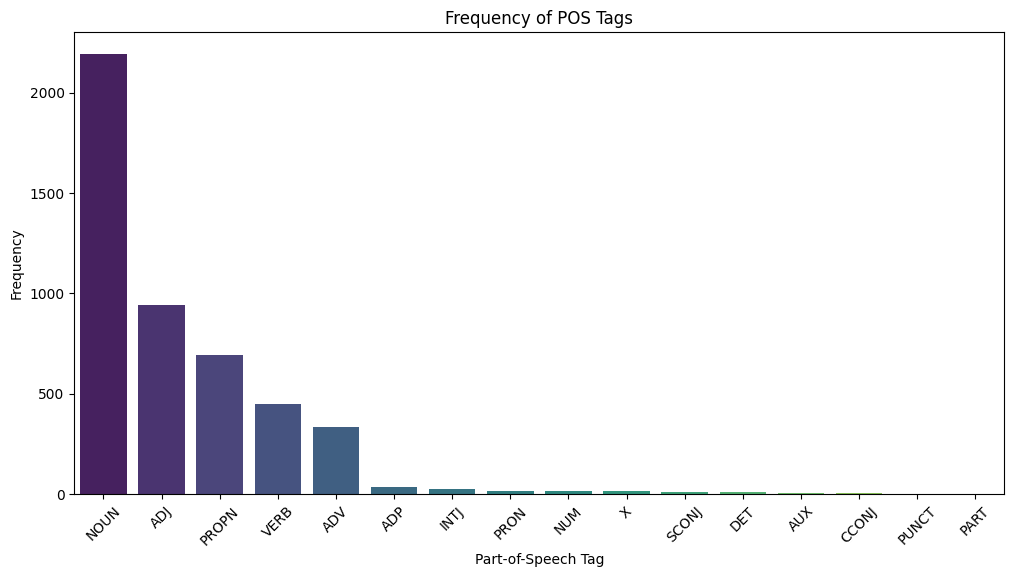

In [ ]:
# POS Tagging
df['pos_tags'] = df['cleaned_text'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

# Extract POS tags and their frequencies
all_pos_tags = [tag for sublist in df['pos_tags'] for tag in sublist]
pos_tag_freq = pd.Series(dict(all_pos_tags)).value_counts()

# Plot POS Tag Frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x=pos_tag_freq.index, y=pos_tag_freq.values, palette='viridis')
plt.xlabel('Part-of-Speech Tag')
plt.ylabel('Frequency')
plt.title('Frequency of POS Tags')
plt.xticks(rotation=45)
plt.show()

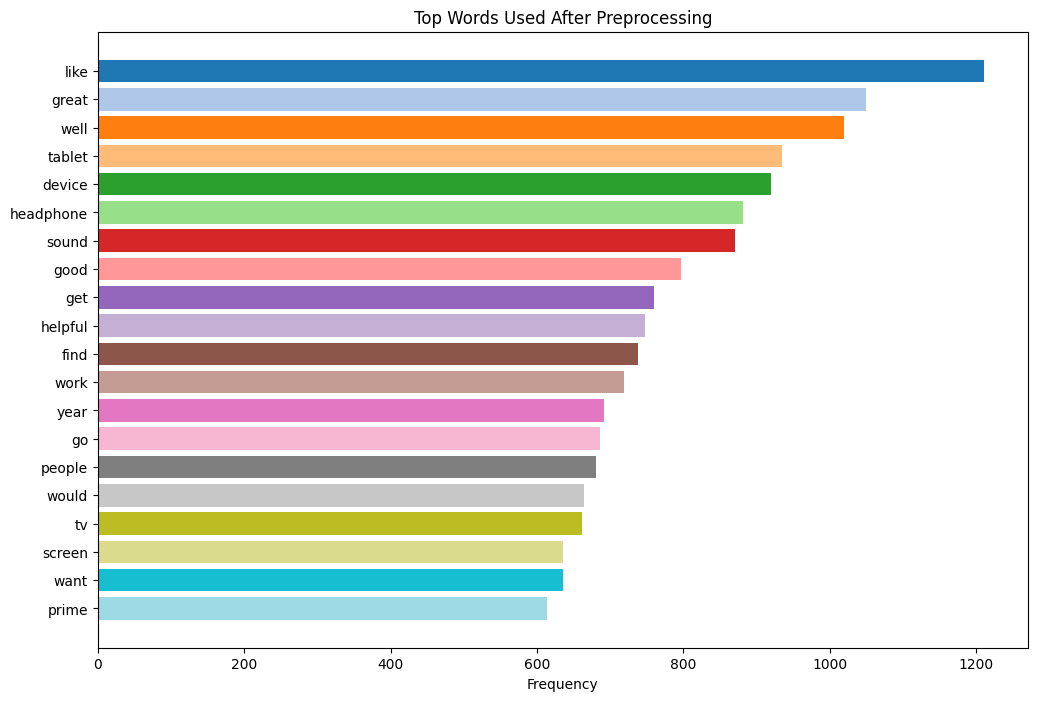

In [ ]:
# Extract most frequently used words
all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

# Plot the most frequently used words
top_words = word_freq.most_common(20)
words, frequencies = zip(*top_words)

plt.figure(figsize=(12, 8))
plt.barh(words, frequencies, color=Category20[20])
plt.xlabel('Frequency')
plt.title('Top Words Used After Preprocessing')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

 ## Generating word cloud

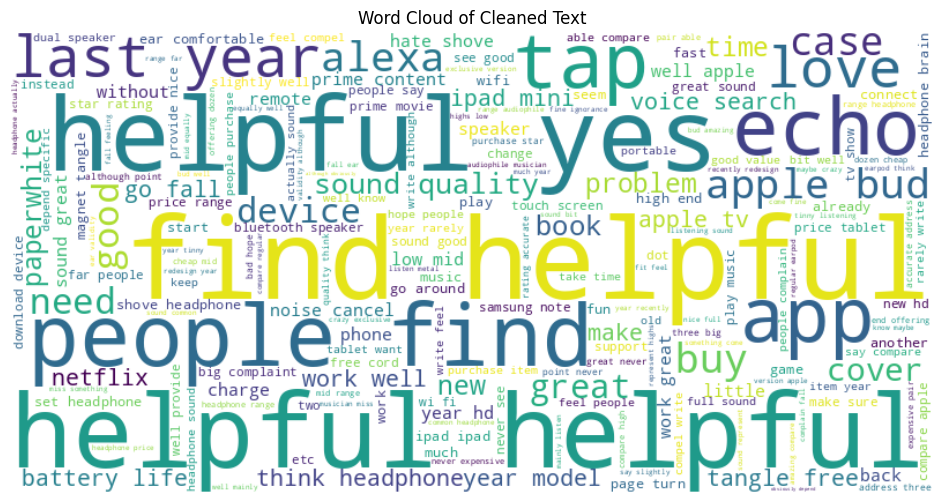

In [ ]:
# Generate and plot word cloud
text_for_wordcloud = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

# LDA Model using Gensim

In [ ]:
# Vectorization for LDA
vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words='english')
data_vectorized = vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# Prepare data for gensim
texts = [text.split() for text in df['cleaned_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the gensim LDA model
gensim_lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Prepare data for pyLDAvis
lda_vis = pyLDAvis.gensim.prepare(gensim_lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


## Frequency Topic Distribution on LDA and plotting bar graph

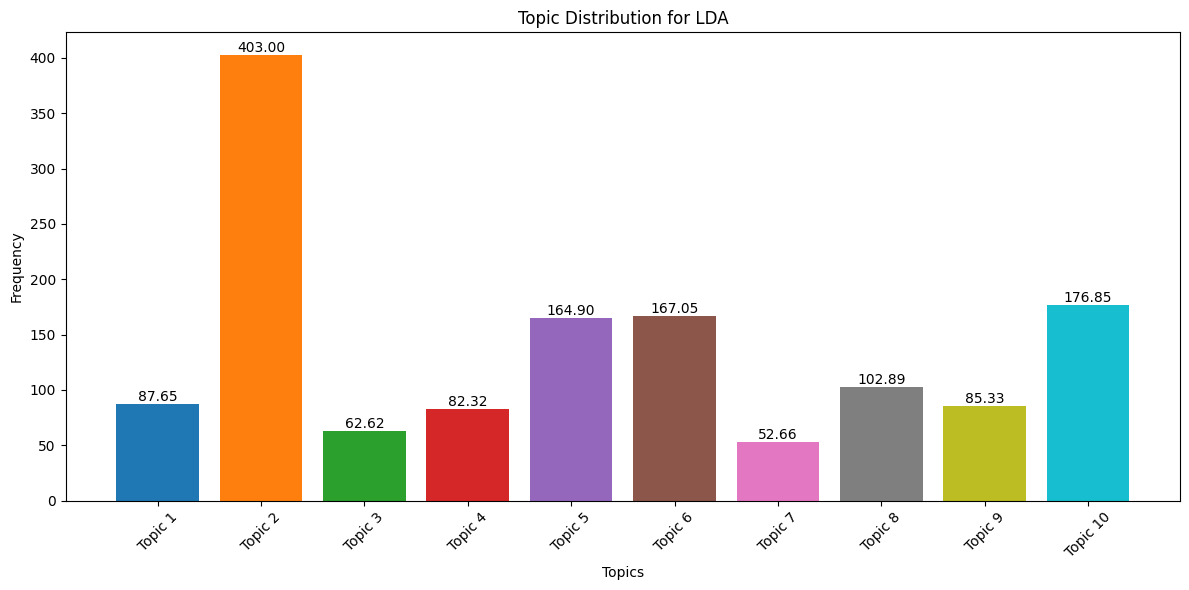

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute topic distribution for LDA
def get_topic_distribution_lda(model, corpus):
    topic_counts = np.zeros(model.num_topics)
    for doc in corpus:
        doc_topics = model.get_document_topics(doc)
        for topic_id, topic_prob in doc_topics:
            topic_counts[topic_id] += topic_prob
    return topic_counts

# Get topic distribution for LDA
topic_freq_lda = get_topic_distribution_lda(gensim_lda_model, corpus)

# Create meaningful topic names based on your analysis
topic_names_lda = [f'Topic {i+1}' for i in range(len(topic_freq_lda))]

# Plot bar chart for LDA
plt.figure(figsize=(12, 6))
bar_colors_lda = plt.get_cmap('tab10').colors  # Get a color map with 10 distinct colors
bars = plt.bar(range(len(topic_freq_lda)), topic_freq_lda, color=bar_colors_lda)

# Add labels to the x-axis
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Topic Distribution for LDA')
plt.xticks(range(len(topic_freq_lda)), topic_names_lda, rotation=45)

# Label bars with frequency values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# T- SNE clustering on LDA document-topic distributions

In [ ]:
# Ensure the correct unpacking of document-topic distributions
doc_topic_distributions = [gensim_lda_model.get_document_topics(bow) for bow in corpus]

# Convert document-topic distributions to a matrix form suitable for t-SNE
num_topics = gensim_lda_model.num_topics
doc_topic_matrix = np.zeros((len(corpus), num_topics))

for i, doc_distribution in enumerate(doc_topic_distributions):
    for topic, prob in doc_distribution:
        doc_topic_matrix[i, topic] = prob

In [ ]:
# Apply t-SNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42)
tsne_lda = tsne_model.fit_transform(doc_topic_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1413 samples in 0.003s...
[t-SNE] Computed neighbors for 1413 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1413
[t-SNE] Computed conditional probabilities for sample 1413 / 1413
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.480042
[t-SNE] KL divergence after 1000 iterations: 0.190597


In [ ]:
import bokeh.plotting as bk
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10

# Prepare data for Bokeh plotting
tsne_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_df['topic'] = doc_topic_matrix.argmax(axis=1)  # Assign the most probable topic


# Map topic numbers to colors
color_map = Category10[len(tsne_df['topic'].unique())]  # Use Category10 palette
tsne_df['color'] = tsne_df['topic'].map(lambda x: color_map[x])

source = ColumnDataSource(tsne_df)

In [ ]:
# Create Bokeh plot
plot = bk.figure(title='t-SNE Clustering of LDA Topics',
                 tools='pan,box_zoom,reset,hover,save',
                 x_axis_label='t-SNE Dimension 1',
                 y_axis_label='t-SNE Dimension 2',
                 width=800, height=800)  # Updated attribute names

plot.scatter(x='x', y='y', source=source,
             fill_color='color', fill_alpha=0.6, size=8, line_color=None)

# Add hover tool to show topic
hover = HoverTool()
hover.tooltips = [("Index", "$index"), ("Topic", "@topic")]
plot.add_tools(hover)

# Show the plot
show(plot)

In [ ]:
# Compute Coherence Score for LDA
coherence_model_lda = CoherenceModel(model=gensim_lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda_score = coherence_model_lda.get_coherence()

# Compute Perplexity for LDA
perplexity_lda = gensim_lda_model.log_perplexity(corpus)

## Performing LSA Model

In [ ]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=10, stop_words='english')
tfidf_data = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# LSA Model
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_data)

In [ ]:
# Perform topic coherence evaluation for LSA using topic words
def get_top_words_for_lsa(model, feature_names, n_words=10):
    top_words = []
    for topic in model.components_:
        top_indices = topic.argsort()[-n_words:][::-1]
        top_words.append([feature_names[i] for i in top_indices])
    return top_words

In [ ]:
# Extract top words for each topic in LSA
feature_names = tfidf_vectorizer.get_feature_names_out()
lsa_topics_top_words = get_top_words_for_lsa(lsa_model, feature_names)
print(lsa_topics_top_words)

[['headphone', 'great', 'sound', 'like', 'speaker', 'love', 'tablet', 'tap', 'good', 'work'], ['headphone', 'bud', 'ear', 'apple', 'range', 'fall', 'earbud', 'people', 'feel', 'compare'], ['tap', 'echo', 'speaker', 'great', 'sound', 'alexa', 'love', 'portable', 'bluetooth', 'music'], ['earbud', 'magnet', 'design', 'headphone', 'cancel', 'noise', 'tangle', 'hate', 'ear', 'set'], ['reader', 'early', 'ipad', 'immediate', 'secondary', 'touch', 'response', 'base', 'tap', 'performance'], ['smartphone', 'samsung', 'gen', 'line', 'note', 'entire', 'remove', 'background', 'generation', 'way'], ['great', 'speaker', 'tablet', 'gig', 'hd', 'camera', 'want', 'large', 'price', 'low'], ['hdx', 'year', 'echo', 'tap', 'hd', 'ipad', 'device', 'download', 'video', 'mini'], ['love', 'book', 'paperwhite', 'buy', 'gift', 'work', 'light', 'new', 'page', 'headphone'], ['love', 'great', 'gift', 'sound', 'speaker', 'prime', 'earbud', 'hdx', 'fun', 'awesome']]


## T- SNE clustering on LSA document-topic distributions

In [ ]:
# LSA Model
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_data)

# Apply t-SNE to LSA topic matrix
tsne_model = TSNE(n_components=2, verbose=1, random_state=42)
tsne_lda = tsne_model.fit_transform(lsa_topic_matrix)

# Prepare data for Bokeh plotting
tsne_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_df['topic'] = np.argmax(lsa_topic_matrix, axis=1)  # Assign the most probable topic
color_map = Category10[len(tsne_df['topic'].unique())]  # Use Category10 palette
tsne_df['color'] = tsne_df['topic'].map(lambda x: color_map[x])

source = ColumnDataSource(tsne_df)

# Initialize Bokeh
output_notebook()

# Create Bokeh plot
plot = figure(title='t-SNE Clustering of LSA Topics',
              tools='pan,box_zoom,reset,hover,save',
              x_axis_label='t-SNE Dimension 1',
              y_axis_label='t-SNE Dimension 2',
              width=800, height=800)

plot.scatter(x='x', y='y', source=source,
             fill_color='color', fill_alpha=0.6, size=8, line_color=None)

# Add hover tool to show topic
hover = HoverTool()
hover.tooltips = [("Index", "$index"), ("Topic", "@topic")]
plot.add_tools(hover)

# Show the plot
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1413 samples in 0.004s...
[t-SNE] Computed neighbors for 1413 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1413
[t-SNE] Computed conditional probabilities for sample 1413 / 1413
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.637527
[t-SNE] KL divergence after 1000 iterations: -0.005786


In [ ]:
# Define a dummy coherence function for LSA (not as robust as for LDA)
def dummy_coherence(top_words):
    return np.mean([len(set(w1).intersection(set(w2))) for w1 in top_words for w2 in top_words])

coherence_lsa_score = dummy_coherence(lsa_topics_top_words)

## LSA Frequency Topic Distibution and plotting using bar graph

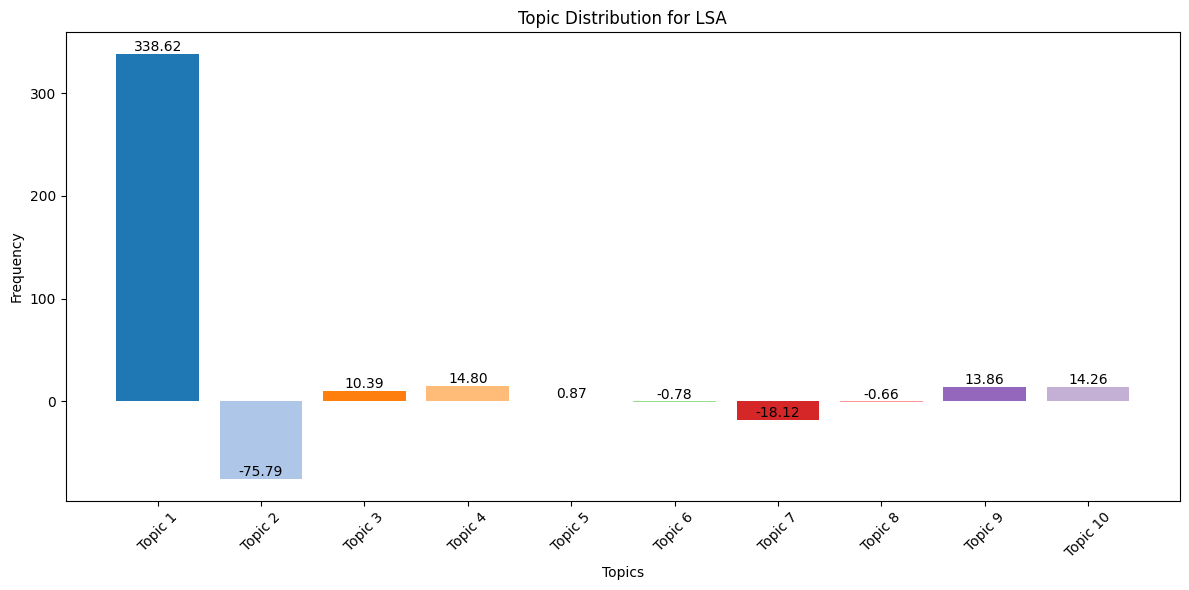

In [ ]:
# Compute topic frequency for LSA
topic_freq_lsa = lsa_topic_matrix.sum(axis=0)

# Create meaningful topic names based on your analysis
topic_names_lsa = [f'Topic {i+1}' for i in range(topic_freq_lsa.shape[0])]

# Plot bar chart for LSA
plt.figure(figsize=(12, 6))
bar_colors_lsa = Category20[10]
bars = plt.bar(range(len(topic_freq_lsa)), topic_freq_lsa, color=bar_colors_lsa)

# Add labels to the x-axis
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Topic Distribution for LSA')
plt.xticks(range(len(topic_freq_lsa)), topic_names_lsa, rotation=45)

# Label bars with frequency values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# Calculate Reconstruction Error for LSA
lsa_reconstruction = lsa_model.inverse_transform(lsa_topic_matrix)
reconstruction_error = np.linalg.norm(tfidf_data - lsa_reconstruction)

In [ ]:
# Print Evaluation Metrics
print(f"LDA Model Coherence Score: {coherence_lda_score}")
print(f"LSA Model Coherence Score (dummy): {coherence_lsa_score}")
print(f"LDA Model Perplexity: {perplexity_lda}")
print(f"LSA Model Reconstruction Error: {reconstruction_error}")

LDA Model Coherence Score: 0.4769742744752884
LSA Model Coherence Score (dummy): 1.88
LDA Model Perplexity: -6.420800223157263
LSA Model Reconstruction Error: 32.11205533218935


##  Recommendation based on Evaluation Metrics

In [ ]:
# Recommendation based on Evaluation Metrics
print("\nComparison and Analysis:")
if coherence_lda_score > coherence_lsa_score:
    print("LDA is preferable for this dataset based on coherence score.")
else:
    print("LSA might be preferable based on alternative criteria.")

if perplexity_lda < 500:  # Example threshold
    print("LDA is preferable based on Perplexity.")
else:
    print("LSA might be preferable based on Reconstruction Error or alternative criteria.")


Comparison and Analysis:
LSA might be preferable based on alternative criteria.
LDA is preferable based on Perplexity.


Comparison and Analysis:
LSA might be preferable based on alternative criteria.
LDA is preferable based on Perplexity.